In [100]:
include("../Source/types.jl")
include("../Source/functions.jl")

testSystem (generic function with 2 methods)

# Test of correct number of vortexes.
When we sum $n_z^\pm(\mathbf{r})$ over all plaquettes in the system we should get $fL^2$ number of vortexes for our 2D system because of our twisted boundary conditions. This is the same as saying $S(\mathbf{0})=1$ since the structure factor has been normalized in this way. We also want to plot snapshots of the system, where we get colors for whether we have a vortex or not.

In [92]:
# Assuming we have a state ψ, we want to find the lattice of vortexes.
function vortexSnapshot(ψ)
    L = ψ.consts.L
    V⁺ = zeros(L,L)
    V⁻ = zeros(L,L)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            V⁺[v_pos,h_pos] += n⁺(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)/two_pi
            V⁻[v_pos,h_pos] += n⁻(ψ.consts, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)/two_pi
        end
    end
    return (V⁺, V⁻)
end

vortexSnapshot (generic function with 1 method)

# Testing this function and plotting a small system

In [ ]:
# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 24     # System length
T = 1.0   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 1000    # Number of measurements
Δt = 400  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

In [94]:
f*L^2

-72.0

In [98]:
function initializeTwoStates(syst::SystConstants, sim::Controls)
    (t₀, E₁, E₂, dE, ψ₁, ψ₂, sim₁, sim₂) = findEquilibrium(syst, sim);
    flush(STDOUT)
    
    N = size(dE, 1)
    int = 1:N
    plt = plot(int, dE[int], title="Energy difference")
    display(plt)
    plt = plot(int, E₁[int], title="Internal energy 1")
    display(plt)
    plt = plot(int, E₂[int], title="Internal energy 2")
    display(plt)
    
    println("Performing extra MCS")
    for i = 1:t₀
        mcSweep!(ψ₂)
        mcSweep!(ψ₁)
        print("$(round(i/t₀*100,2))%\r")
    end
    
    println("Calculating energies and acceptance rates")
    T = 4000
    dE = zeros(2T)
    E₁ = zeros(2T)
    E₂ = zeros(2T)
    p₁ = zeros(2T)
    p₂ = zeros(2T)
    for i = 1:T
        E₁[i] = E(ψ₁)
        E₂[i] = E(ψ₂)
        dE[i] = E₂[i]-E₁[i]
        p₁[i] = mcSweepFrac!(ψ₁, sim₁)
        p₂[i] = mcSweepFrac!(ψ₂, sim₂)
    end
    adjustSimConstants!(sim₁, ψ₁)
    adjustSimConstants!(sim₂, ψ₂)
    for i = T+1:2T
        E₁[i] = E(ψ₁)
        E₂[i] = E(ψ₂)
        dE[i] = E₂[i]-E₁[i]
        p₁[i] = mcSweepFrac!(ψ₁, sim₁)
        p₂[i] = mcSweepFrac!(ψ₂, sim₂)
    end

    # Plotting results
    plt = plot(1:2T, dE, title="Energy difference")
    display(plt)
    plt = plot(1:2T, E₁, title="Internal energy 1")
    display(plt)
    plt = plot(1:2T, E₂, title="Internal energy 2")
    display(plt)
    plt = plot(1:2T, p₁, title="Accept probability 1")
    display(plt)
    plt = plot(1:2T, p₂, title="Accept probability 2")
    display(plt)
    
    return (ψ₁, sim₁, ψ₂, sim₂)
end

initializeTwoStates (generic function with 1 method)

In [ ]:
(ψ₁, sim₁, ψ₂, sim₂) = initializeTwoStates(syst, sim);

Finding Equilibrium of
SystConstants(24, 1.0, 11.11111111111111, 0.3, -0.125, 1.0)
Controls(1.0471975511965976, 0.4, 0.2633744855967078)
Searching for ΔE <= 0..


In [15]:
vortexMatrix⁺, vortexMatrix⁻ = vortexSnapshot(ψ₁)

([0.152383 -0.890085 … 0.145002 0.0782679; 0.0997703 1.13815 … 1.14523 0.0480718; … ; -0.911946 0.0435781 … -0.881298 1.14221; 0.109713 1.12308 … 0.141105 0.175349], [0.152383 -0.890085 … -0.854998 1.07827; 0.0997703 0.138147 … 0.145228 0.0480718; … ; 0.0880541 0.0435781 … 0.118702 0.142211; -0.890287 1.12308 … 0.141105 0.175349])

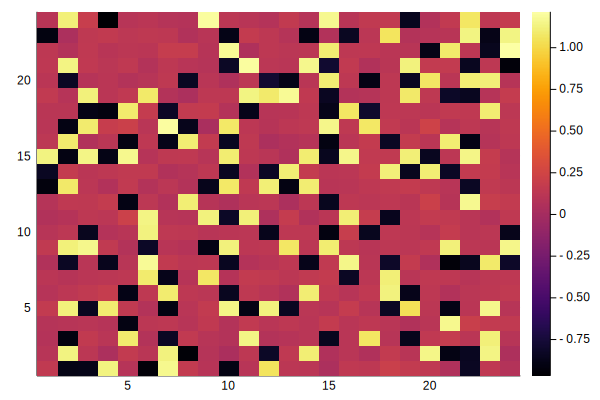

In [16]:
heatmap(1:L, 1:L, vortexMatrix⁺)

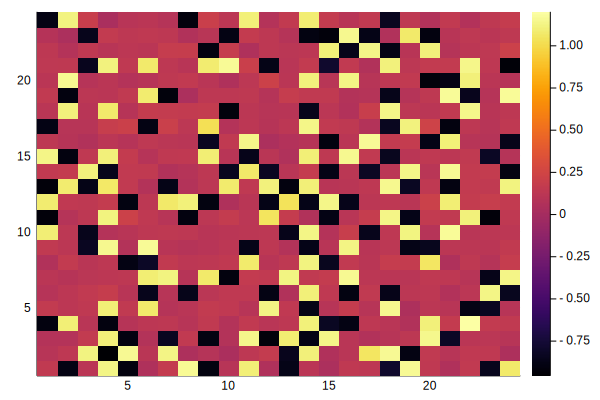

In [17]:
heatmap(1:L, 1:L, vortexMatrix⁻)

In [57]:
# We combine the two component vortex lattices into one lattice where
# 0: (-1, -1), 1: (-1, 0), 2: (-1, 1)
# 3: (0, -1), 4: (0, 0), 5: (0, 1)
# 6: (1, -1), 7: (1, 0), 8: (1, 1)
function combineVortexLattices{T<:Real}(vortex_matrix⁺::Array{T, 2}, vortex_matrix⁻::Array{T,2})
    L = size(vortex_matrix⁺,1)
    A = [-1 for x=1:L, y=1:L]
    for v_pos = 1:L, h_pos = 1:L
        if isapprox(vortex_matrix⁺[v_pos, h_pos], -1.0, atol=0.3)
            if isapprox(vortex_matrix⁻[v_pos, h_pos], -1.0, atol=0.3)
                A[v_pos, h_pos] = 0
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 0.0, atol=0.3)
                A[v_pos, h_pos] = 1
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 1.0, atol=0.3)
                A[v_pos, h_pos] = 2
            end
        elseif isapprox(vortex_matrix⁺[v_pos, h_pos], 0.0, atol=0.3)
            if isapprox(vortex_matrix⁻[v_pos, h_pos], -1.0, atol=0.3)
                A[v_pos, h_pos] = 3
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 0.0, atol=0.3)
                A[v_pos, h_pos] = 4
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 1.0, atol=0.3)
                A[v_pos, h_pos] = 5
            end
        elseif isapprox(vortex_matrix⁺[v_pos, h_pos], 1.0, atol=0.3)
            if isapprox(vortex_matrix⁻[v_pos, h_pos], -1.0, atol=0.3)
                A[v_pos, h_pos] = 6
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 0.0, atol=0.3)
                A[v_pos, h_pos] = 7
            elseif isapprox(vortex_matrix⁻[v_pos, h_pos], 1.0, atol=0.3)
                A[v_pos, h_pos] = 8
            end
        end
    end
    return A
end

combineVortexLattices (generic function with 1 method)

In [58]:
vortexMatrix⁺

24×24 Array{Float64,2}:
  0.152383   -0.890085   -0.8826     …  -0.842075   0.145002    0.0782679
  0.0997703   1.13815     0.125897      -0.8501     1.14523     0.0480718
  0.0859945  -0.917948    0.161611       0.118154   1.12201     0.100599 
  0.0925309   0.103659    0.111782       0.201555   0.164643    0.151854 
  0.164539    1.12708    -0.852435       0.117431   1.16216     0.101872 
  0.0960432   0.129207    0.154943   …   0.121667   0.136822    0.152481 
  0.118322    0.0973016   0.120291       0.1022     0.131835    0.139695 
  0.0694402  -0.837792    0.11421       -0.856338   1.09047    -0.820019 
  0.154852    1.12508     1.16302        0.125559   0.118796    1.1593   
  0.101121    0.132029   -0.856464       0.113994   0.125887   -0.870567 
  0.0707957   0.0891951   0.134522   …   0.112885   0.0736032   0.148321 
  0.090265    0.14933     0.143001       1.17031    0.190076    0.16626  
 -0.925884    1.08902     0.122324      -0.837411   0.153924    0.124966 
 -0.841098    

In [59]:
isapprox(vortexMatrix⁺[1,1], 0.0, atol=0.3)

true

In [60]:
combinedMatrix = combineVortexLattices(vortexMatrix⁺, vortexMatrix⁻)

24×24 Array{Int64,2}:
 4  0  1  8  3  1  7  5  3  1  5  7  3  4  4  4  4  3  5  4  4  1  3  5
 4  7  5  3  5  4  8  1  4  4  4  1  3  8  4  4  5  5  3  7  1  1  7  4
 4  1  4  5  6  4  0  4  3  4  8  3  5  3  2  4  7  4  1  5  3  4  7  4
 3  5  4  3  1  4  4  4  4  4  4  4  4  5  3  3  4  4  4  5  7  5  4  4
 4  7  1  8  4  5  1  4  4  7  1  8  1  3  4  4  4  2  7  4  1  3  6  4
 4  4  4  4  1  3  7  3  4  1  4  3  4  8  4  3  4  6  1  4  4  4  5  3
 4  4  4  4  4  8  2  4  8  3  4  4  5  4  4  2  4  7  4  4  4  4  3  5
 4  1  4  1  3  6  4  4  4  1  5  4  4  2  3  7  4  1  4  5  1  1  7  1
 4  7  6  5  4  2  4  4  1  7  3  4  7  3  7  5  4  4  3  3  7  4  4  7
 5  4  0  4  4  7  4  4  4  4  4  1  3  5  1  4  0  4  5  4  5  4  4  1
 3  4  4  5  4  7  4  3  7  1  7  5  4  4  3  7  4  2  3  4  4  5  3  4
 5  4  4  4  0  4  5  8  3  4  4  3  5  3  2  3  4  4  4  4  5  7  4  4
 0  8  3  5  4  4  3  4  1  8  4  8  0  8  4  4  4  5  3  4  3  1  4  5
 1  4  5  3  4  4  4  4  4  0  5  0  7  4 

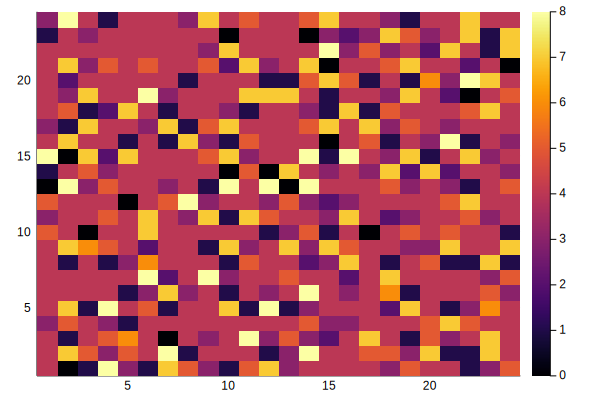

In [61]:
heatmap(1:L, 1:L, combinedMatrix)

In [64]:
# Finding the proportion of the different kinds of vortices
av_vortex_kinds = zeros(9)
for v_pos = 1:L, h_pos = 1:L
    av_vortex_kinds[combinedMatrix[v_pos, h_pos]+1] += 1
end
av_vortex_kinds *= 100/L^2

9-element Array{Float64,1}:
  2.77778
 10.2431 
  3.125  
 13.3681 
 44.0972 
 10.2431 
  1.04167
 11.2847 
  3.81944

In [21]:
sum⁺ = 0.0
sum⁻ = 0.0
for h_pos = 1:L, v_pos = 1:L
    sum⁺ += vortexMatrix⁺[v_pos, h_pos]
    sum⁻ += vortexMatrix⁻[v_pos, h_pos]
end
@show sum⁺
@show sum⁻

sum⁺ = 72.0
sum⁻ = 71.99999999999991


71.99999999999991

In [23]:
# Calculates an average lattice over M MCS with Δt MCS in between
function vortexLatticeAvg!(ψ::State, sim::Controls, M::Int64, Δt::Int64)
    syst = ψ.consts
    L = syst.L
    
    V⁺ = [zeros(L,L) for i=1:M]    # Matrix containing the series of measurements for each position
    V⁻ = [zeros(L,L) for i=1:M]
    Sm⁺ = zeros(L,L)
    Sm⁻ = zeros(L,L)
    avV⁺ = zeros(L,L)
    avV⁻ = zeros(L,L)
    
    println("Making $(M) measurements over a $(L)×$(L) lattice, with Δt=$(Δt)")
    # Loop over M measurements
    for m = 1:M
        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim)
        end
        
        (V⁺[m], V⁻[m]) = vortexSnapshot(ψ)
        
        # Calculate averages and second moments. 
        for y = 1:L, x = 1:L
            avV⁺[y,x] += V⁺[m][y,x]
            avV⁻[y,x] += V⁻[m][y,x]
            Sm⁺[y,x] += V⁺[m][y,x]^2
            Sm⁻[y,x] += V⁻[m][y,x]^2
        end
    end
    
    τ⁺ = [autocorrTime([V⁺[m][y,x] for m=1:M], 5.0) for y=1:L, x=1:L]
    τ⁻ = [autocorrTime([V⁻[m][y,x] for m=1:M], 5.0) for y=1:L, x=1:L]
    errV⁺ = zeros(L,L)
    errV⁻ = zeros(L,L)
    
    for y=1:L, x=1:L
        Sm⁺[y,x] /= M
        Sm⁻[y,x] /= M
        avV⁺[y,x] /= M
        avV⁻[y,x] /= M
        errV⁺[y,x] = (1+2*τ⁺[y,x])*(Sm⁺[y,x] - avV⁺[y,x]^2)/(M-1)
        errV⁻[y,x] = (1+2*τ⁻[y,x])*(Sm⁻[y,x] - avV⁻[y,x]^2)/(M-1)
    end
    
    return (avV⁺, errV⁺, V⁺, avV⁻, errV⁻, V⁻)
end

vortexLatticeAvg! (generic function with 1 method)

In [66]:
# Take in a matrix of k-values and calculate both the vorticity of θ⁺ and θ⁻.
# Same as previous structureFunction, but now assumes the state is at equilibrium
function structureFunctionVortexLatticeAvg!{T<:Real}(ks::Array{Array{T, 1}, 2}, 
        ψ::State, sim::Controls, M::Int64, Δt::Int64)
    syst = ψ.consts
    L = syst.L
    
    # Setup structure factor storage
    Lky = size(ks, 1)
    Lkx = size(ks, 2)
    S⁺ = [zeros(M) for y=1:Lky, x=1:Lkx]    # Matrix containing the series of measurements for each k
    S⁻ = [zeros(M) for y=1:Lky, x=1:Lkx]
    Sm⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    Sm⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    s_norm_inv = 1/(syst.f*syst.L^2*two_pi)^2
    
    # Setup vortex lattice storage
    V⁺ = [zeros(L,L) for i=1:M]    # Matrix containing the series of measurements for each position
    V⁻ = [zeros(L,L) for i=1:M]
    VSm⁺ = zeros(L,L)
    VSm⁻ = zeros(L,L)
    avV⁺ = zeros(L,L)
    avV⁻ = zeros(L,L)
    
    println("Making measurements over a $(Lkx)×$(Lky) matrix of ks.")
    # Loop over M measurements
    for m = 1:M
        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim)
        end
        
        # Find n_z(r) of the lattice.
        (V⁺[m], V⁻[m]) = vortexSnapshot(ψ)
        
        # Calculate average of vorticity and vorticity second moment. 
        for y = 1:L, x = 1:L
            avV⁺[y,x] += V⁺[m][y,x]
            avV⁻[y,x] += V⁻[m][y,x]
            VSm⁺[y,x] += V⁺[m][y,x]^2
            VSm⁻[y,x] += V⁻[m][y,x]^2
        end
        
        # Find structure factor. 
        for y = 1:Lky, x = 1:Lkx
            (S⁺[y,x][m], S⁻[y,x][m]) = s_norm_inv.*structureFunction(ks[y,x], ψ)
            Sm⁺[y,x] += S⁺[y,x][m]^2
            Sm⁻[y,x] += S⁻[y,x][m]^2
        end
    end
    
    # Error calculation of average vorticity
    τ_V⁺ = [autocorrTime([V⁺[m][y,x] for m=1:M], 5.0) for y=1:L, x=1:L]
    τ_V⁻ = [autocorrTime([V⁻[m][y,x] for m=1:M], 5.0) for y=1:L, x=1:L]
    errV⁺ = zeros(L,L)
    errV⁻ = zeros(L,L)
    
    for y=1:L, x=1:L
        VSm⁺[y,x] /= M
        VSm⁻[y,x] /= M
        avV⁺[y,x] /= M
        avV⁻[y,x] /= M
        errV⁺[y,x] = (1+2*τ_V⁺[y,x])*(VSm⁺[y,x] - avV⁺[y,x]^2)/(M-1)
        errV⁻[y,x] = (1+2*τ_V⁻[y,x])*(VSm⁻[y,x] - avV⁻[y,x]^2)/(M-1)
    end
    
    # Error calculation of structure factor.
    avS⁺ = [mean(S⁺[y,x]) for y=1:Lky, x=1:Lkx]
    avS⁻ = [mean(S⁻[y,x]) for y=1:Lky, x=1:Lkx]
    τ_S⁺ = [autocorrTime(S⁺[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    τ_S⁻ = [autocorrTime(S⁻[y,x], 5.0) for y=1:Lky, x=1:Lkx]
    errS⁺ = [0.0 for y=1:Lky, x=1:Lkx]
    errS⁻ = [0.0 for y=1:Lky, x=1:Lkx]
    
    for y=1:Lky, x=1:Lkx
        Sm⁺[y,x] /= M
        Sm⁻[y,x] /= M
        errS⁺[y,x] = (1+2*τ_S⁺[y,x])*(Sm⁺[y,x] - avS⁺[y,x]^2)/(M-1)
        errS⁻[y,x] = (1+2*τ_S⁻[y,x])*(Sm⁻[y,x] - avS⁻[y,x]^2)/(M-1)
    end
    
    return (avV⁺, errV⁺, V⁺, avV⁻, errV⁻, V⁻, avS⁺, errS⁺, S⁺, avS⁻, errS⁻, S⁻)
end


structureFunctionVortexLatticeAvg! (generic function with 1 method)

Making measurements over a 24×24 matrix of ks.


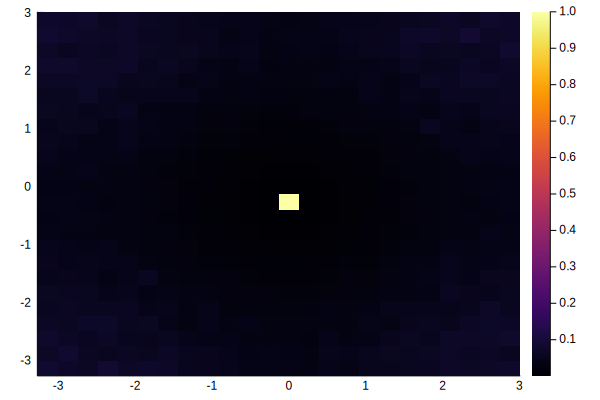

In [67]:
M = 100
Δt = 100
ψ = copy(ψ₁)
sim = copy(sim₁)


# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]

# Calculate thermal average
(avV⁺, errV⁺, V⁺, avV⁻, errV⁻, V⁻, avS⁺, errS⁺, S⁺, avS⁻, errS⁻, S⁻) = structureFunctionVortexLatticeAvg!(k_matrix, ψ, sim, M, Δt)

# Plot result for + component
heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺)

In [89]:
function plotStructureFunctionAndVortexLattice{T<:Real}(avV⁺::Array{T, 2}, avV⁻::Array{T, 2}, 
        V⁺::Array{T, 2}, V⁻::Array{T,2}, avS⁺::Array{T, 2}, avS⁻::Array{T,2})
    L = size(avV⁺,1)
    # Plotting structure factor
    plt = heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺, title="average S+", xlabel="k_x", ylabel="k_y")
    display(plt)
    plt = heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁻, title="average S-", xlabel="k_x", ylabel="k_y")
    display(plt)
    
    # Removing middle-point
    println("S⁺(0) ≈ $(avS⁺[Int(ceil(L/2)), Int(ceil(1+L/2))])")
    temp⁺ = avS⁺[Int(ceil(L/2)), Int(ceil(1+L/2))]
    avS⁺[Int(ceil(L/2)), Int(ceil(1+L/2))] = avS⁺[Int(ceil(1+L/2)), Int(ceil(L/2))]
    println("S⁻(0) ≈ $(avS⁻[Int(ceil(L/2)), Int(ceil(1+L/2))])")
    temp⁻ = avS⁻[Int(ceil(L/2)), Int(ceil(1+L/2))]
    avS⁻[Int(ceil(L/2)), Int(ceil(1+L/2))] = avS⁻[Int(ceil(1+L/2)), Int(ceil(L/2))]
    
    # And then re-plotting
    plt = heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁺, 
        title="average S+ with S(0) removed", xlabel="k_x", ylabel="k_y")
    display(plt)
    plt = heatmap(-π:2π/L:π*(L-2)/L, -π:2π/L:π*(L-2)/L, avS⁻, 
        title="average S- with S(0) removed", xlabel="k_x", ylabel="k_y")
    display(plt)
    
    # Restoring middle point
    avS⁺[Int(ceil(L/2)), Int(ceil(1+L/2))] = temp⁺
    avS⁻[Int(ceil(L/2)), Int(ceil(1+L/2))] = temp⁻
    
    # Plotting vortex snapshots
    plt = heatmap(1:L, 1:L, V⁺, title="Snapshot of + component vorticity", xlabel="x", ylabel="y")
    display(plt)
    plt = heatmap(1:L, 1:L, V⁻, title="Snapshot of - component vorticity", xlabel="x", ylabel="y")
    display(plt)
    
    # Combining matrices
    combined_lattice = combineVortexLattices(V⁺, V⁻)
    plt = heatmap(1:L, 1:L, combined_lattice, title="Combination of snapshots", xlabel="x", ylabel="y")
    display(plt)
    
    # Finding the proportion of the different kinds of vortices in combined matrix
    av_vortex_kinds = zeros(9)
    for v_pos = 1:L, h_pos = 1:L
        av_vortex_kinds[combinedMatrix[v_pos, h_pos]+1] += 1
    end
    av_vortex_kinds *= 100/L^2
    println("The proportion of vortices (n⁺, n⁻) in snapshot")
    println("% of vortex kind (-1, -1): \t$(Int(round(av_vortex_kinds[1],0)))")
    println("% of vortex kind (-1, 0): \t$(Int(round(av_vortex_kinds[2],0)))")
    println("% of vortex kind (-1, 1): \t$(Int(round(av_vortex_kinds[3],0)))")
    println("% of vortex kind (0, -1): \t$(Int(round(av_vortex_kinds[4],0)))")
    println("% of vortex kind (0, 0): \t$(Int(round(av_vortex_kinds[5],0)))")
    println("% of vortex kind (0, 1): \t$(Int(round(av_vortex_kinds[6],0)))")
    println("% of vortex kind (1, -1): \t$(Int(round(av_vortex_kinds[7],0)))")
    println("% of vortex kind (1, 0): \t$(Int(round(av_vortex_kinds[8],0)))")
    println("% of vortex kind (1, 1): \t$(Int(round(av_vortex_kinds[9],0)))\n")
    
    # Calculating the sum of vortices of snapshot
    sum⁺ = 0.0
    sum⁻ = 0.0
    for h_pos = 1:L, v_pos = 1:L
        sum⁺ += V⁺[v_pos, h_pos]
        sum⁻ += V⁻[v_pos, h_pos]
    end
    println("Sum of + component vorticity in the snapshot: $(sum⁺)")
    println("Sum of - component vorticity in the snapshot: $(sum⁻)")
    flush(STDOUT)
    
    # Plotting vortex averages
    plt = heatmap(1:L, 1:L, avV⁺, title="Average + component vorticity", xlabel="x", ylabel="y")
    display(plt)
    plt = heatmap(1:L, 1:L, avV⁻, title="Average - component vorticity", xlabel="x", ylabel="y")
    display(plt)
end 

plotStructureFunctionAndVortexLattice (generic function with 1 method)

In [90]:
Int(round(1.03214,0))

1

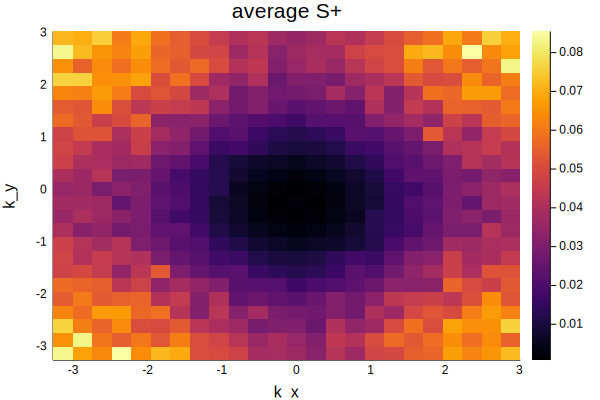

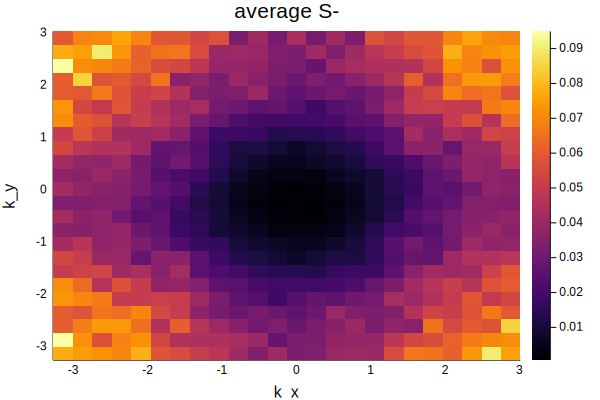

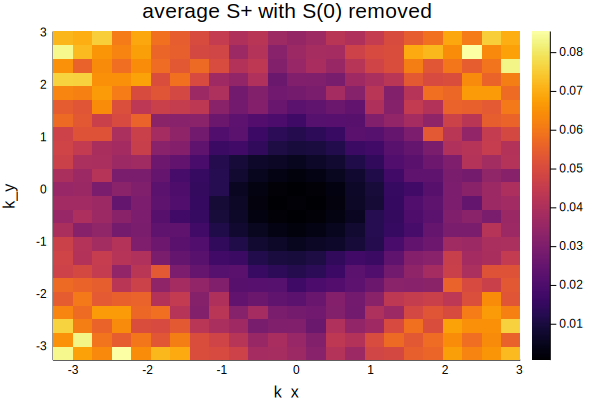

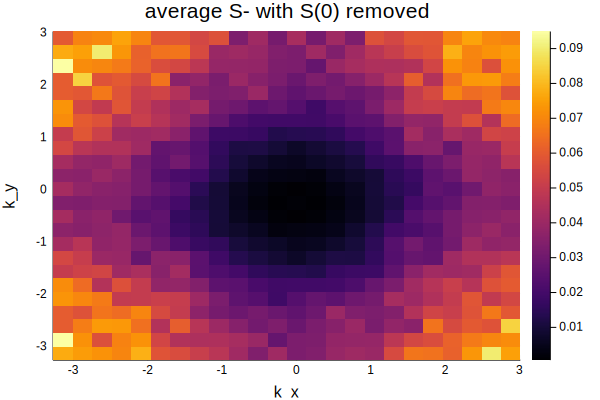

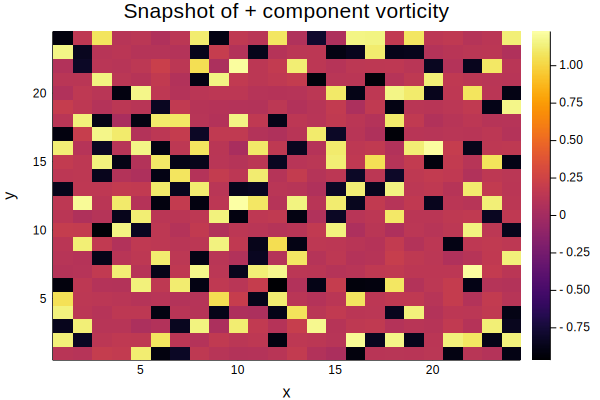

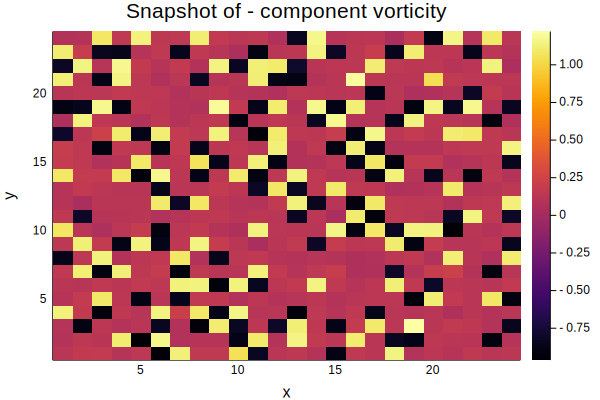

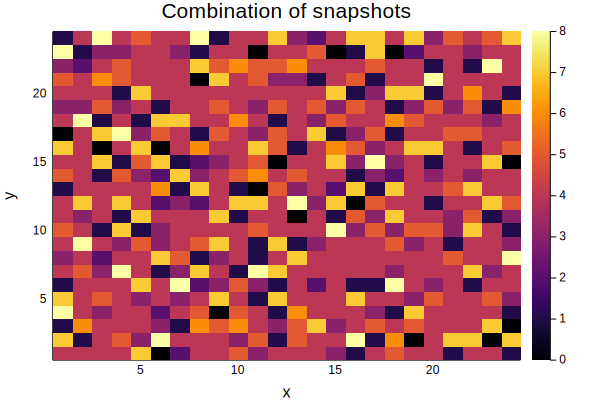

S⁺(0) ≈ 0.001295623788849228
S⁻(0) ≈ 0.0013333172847511357
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	3
% of vortex kind (-1, 0): 	10
% of vortex kind (-1, 1): 	3
% of vortex kind (0, -1): 	13
% of vortex kind (0, 0): 	44
% of vortex kind (0, 1): 	10
% of vortex kind (1, -1): 	1
% of vortex kind (1, 0): 	11
% of vortex kind (1, 1): 	4

Sum of + component vorticity in the snapshot: 72.00000000000001
Sum of - component vorticity in the snapshot: 72.00000000000006


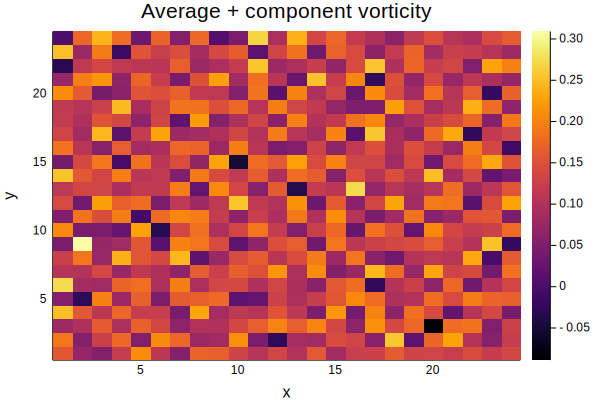

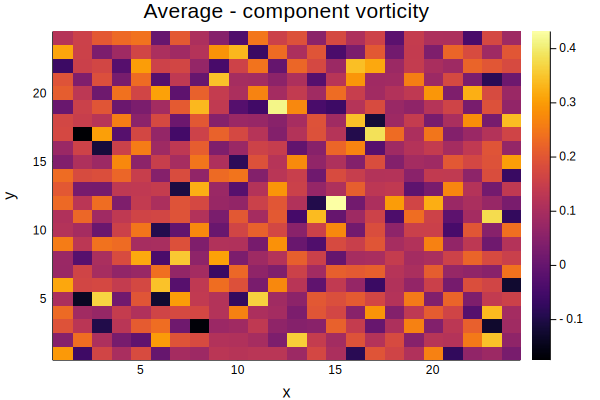

In [91]:
plotStructureFunctionAndVortexLattice(avV⁺, avV⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], avS⁺, avS⁻)

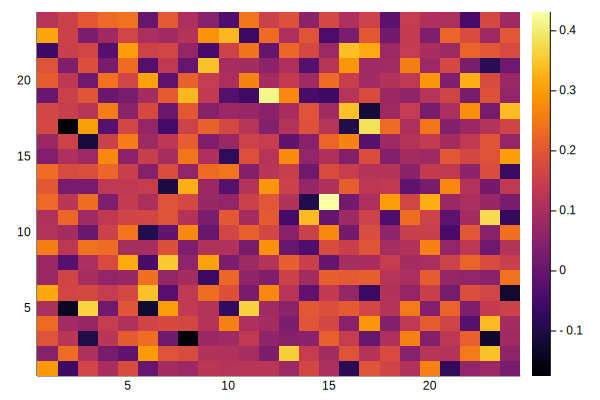

In [69]:
heatmap(1:L, 1:L, avV⁻)